In [1]:
import pandas as pd
import numpy as np

from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder
import sys
sys.path.append("/home/leon/projects/gaussian_process/")
from sklearn.model_selection import cross_val_score
from gecs100.gec import GEC
from gecs100.utils.gaussian_process_visualisation import visualise_1D_gaussian_process, visualise_2D_gaussian_process

gec = GEC()
gec.load_gp_datas("/home/leon/projects/100gecs/data/gp_datas.json")


In [2]:
path = "/home/leon/learning/gaussian-processes/bank/bank-full.csv"
data = pd.read_csv(path, sep=";")
one_hot_encode = ["job", "marital", "education", "contact", "poutcome", "month"]
binary = ["default", "housing", "loan", "y"]

enc = OneHotEncoder()
def yesNoBinary(column):
    return(pd.DataFrame([1 if value == "yes" else 0 for value in column], columns = [column.name]))
one_hot = pd.DataFrame(enc.fit_transform(data[one_hot_encode]).toarray(), columns=enc.get_feature_names_out(one_hot_encode))
data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)
X, y = data2.values[:,:-1], data2.values[:,-1]
ind = np.random.uniform(0, 1, X.shape[0]) > 0.3
X = X[ind,:]
y = y[ind]

X_pos = X[y==1,:]
y_pos = y[y==1]

X_reweighted = np.concatenate([X] + [X_pos]*3, axis=0)
y_reweighted = np.concatenate([y] + [y_pos]*3)

/tmp/ipykernel_43705/3574338328.py:10: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)
/tmp/ipykernel_43705/3574338328.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)


In [3]:
gec.fit(X_reweighted, y_reweighted, 1)

[LightGBM] [Warning] lambda_l1 is set=0.08305871111196488, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08305871111196488
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.7099999999999996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7099999999999996
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] lambda_l1 is set=0.08305871111196488, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08305871111196488
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.7099999999999996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7099999999999996
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignore

GEC(boosting='gbdt', feature_fraction=0.19999999999999996,
    lambda_l1=0.2527276847641921, learning_rate=0.050725716239252885,
    min_data_in_leaf=42, num_leaves=171)

In [4]:
print(gec.best_params_)
knn_bayes = LGBMClassifier(**gec.best_params_)
score_bayes = np.mean(cross_val_score(knn_bayes, X, y, cv=5))
score_bayes

{'boosting': 'gbdt', 'lambda_l1': 0.08305871111196488, 'num_leaves': 171, 'min_data_in_leaf': 29, 'feature_fraction': 0.7099999999999996, 'learning_rate': 0.09481107273415215}
[LightGBM] [Warning] lambda_l1 is set=0.08305871111196488, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08305871111196488
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.7099999999999996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7099999999999996
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] lambda_l1 is set=0.08305871111196488, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08305871111196488
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.709999999999999

0.6487652570444717

In [5]:
print(gec.best_params_grid)
knn_bayes = LGBMClassifier(**gec.best_params_grid)
score_bayes = np.mean(cross_val_score(knn_bayes, X, y, cv=5))
score_bayes

{'boosting': 'gbdt', 'lambda_l1': 0.2527276847641921, 'num_leaves': 171, 'min_data_in_leaf': 42, 'feature_fraction': 0.19999999999999996, 'learning_rate': 0.050725716239252885}
[LightGBM] [Warning] lambda_l1 is set=0.2527276847641921, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2527276847641921
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.19999999999999996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19999999999999996
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] lambda_l1 is set=0.2527276847641921, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2527276847641921
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.1999999999999999

0.7642769455739689

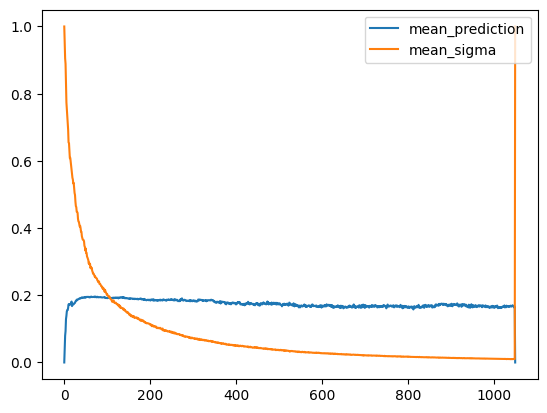

In [6]:

import matplotlib.pyplot as plt
x = np.arange(len(gec.gp_datas["gbdt"]["means"]))
gp_mean_prediction = [np.mean(x) for x in gec.gp_datas["gbdt"]["means"]]
gp_mean_sigma = [np.mean(x) for x in gec.gp_datas["gbdt"]["sigmas"]]

plt.plot(x, gp_mean_prediction, label="mean_prediction")
plt.plot(x, gp_mean_sigma, label="mean_sigma")
plt.legend(loc="upper right")

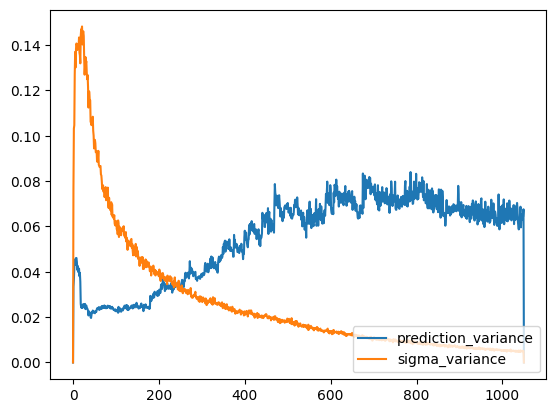

In [7]:

import matplotlib.pyplot as plt
x = np.arange(len(gec.gp_datas["gbdt"]["means"]))
gp_prediction_variance = [np.std(x) for x in gec.gp_datas["gbdt"]["means"]]
gp_sigma_variance = [np.std(x) for x in gec.gp_datas["gbdt"]["sigmas"]]

plt.plot(x, gp_prediction_variance, label="prediction_variance")
plt.plot(x, gp_sigma_variance, label="sigma_variance")
plt.legend(loc="lower right")

/home/leon/miniconda3/envs/dev/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


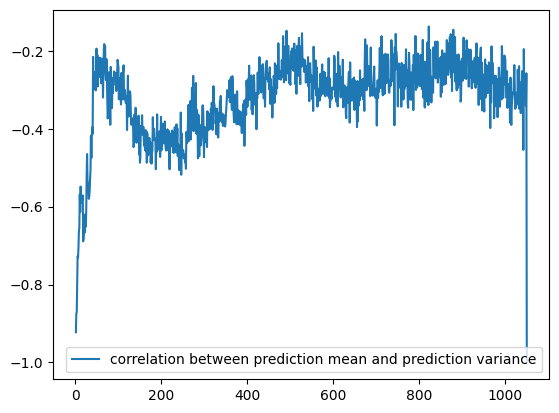

In [8]:

import matplotlib.pyplot as plt
x = np.arange(len(gec.gp_datas["gbdt"]["means"]))
correlation = [np.corrcoef(gec.gp_datas["gbdt"]["means"][i], gec.gp_datas["gbdt"]["sigmas"][i])[0,1] for i in x]

plt.plot(x, correlation, label="correlation between prediction mean and prediction variance")
plt.legend(loc="lower right")



In [15]:
np.array([np.mean(gec.gp_datas["gbdt"]["output"][i:i+10]) for i in range(1040)])

array([0.68867582, 0.69285165, 0.6936132 , ..., 0.70322672, 0.70083661,
       0.696519  ])

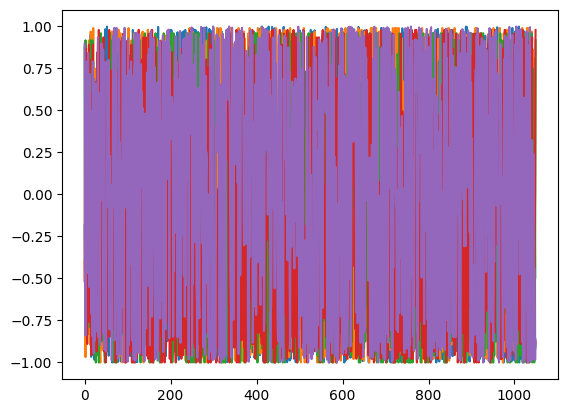

In [18]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib.pyplot as plt
inputs_ = np.array(gec.gp_datas["gbdt"]["inputs"])
x = np.arange(inputs_.shape[0])
for i in range(inputs_.shape[1]):
    plt.plot(x, inputs_[:,i], label ='y1')


In [20]:
np.mean(gec.predict(X))

0.15226363578639915

In [21]:
print(gec.best_params_)
knn_bayes = LGBMClassifier(**gec.best_params_)
score_bayes = np.mean(cross_val_score(knn_bayes, X, y, cv=5))
score_bayes

{'boosting': 'gbdt', 'lambda_l1': 0.008229572592603695, 'num_leaves': 196, 'min_data_in_leaf': 6, 'feature_fraction': 0.13, 'learning_rate': 0.16788040181225597}
[LightGBM] [Warning] lambda_l1 is set=0.008229572592603695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008229572592603695
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.13, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] lambda_l1 is set=0.008229572592603695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008229572592603695
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.13, colsample_bytree=1.0 will be ignored. Current value

0.7616280336762953

In [22]:
from sklearn.model_selection import RandomizedSearchCV
classifier = LGBMClassifier()
hyperparams = dict(gec.categorical_hyperparameters + gec.real_hyperparameters)
gs = RandomizedSearchCV(classifier, hyperparams, n_iter=50)
gs.fit(X_reweighted, y_reweighted)

[LightGBM] [Warning] lambda_l1 is set=0.6537724521828331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6537724521828331
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.2599999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2599999999999999
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0.6537724521828331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6537724521828331
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.2599999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2599999999999999
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. C

RandomizedSearchCV(estimator=LGBMClassifier(), n_iter=50,
                   param_distributions={'boosting': ['gbdt'],
                                        'feature_fraction': [0.1, 0.11, 0.12,
                                                             0.13,
                                                             0.13999999999999999,
                                                             0.14999999999999997,
                                                             0.15999999999999998,
                                                             0.16999999999999998,
                                                             0.17999999999999997,
                                                             0.18999999999999995,
                                                             0.19999999999999996,
                                                             0.20999999999999996,
                                                             0.21999999999999995,
                                                             0.22999999999999995,
                                                             0.239999999999...
       9.92343535e-01, 9.94889810e-01, 9.97441960e-01, 1.00000000e+00]),
                                        'learning_rate': array([0.01002305, 0.01004616, 0.01006932, ..., 0.31477483, 0.31550046,
       0.31622777]),
                                        'min_data_in_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9, 10, 11, 12,
                                                             13, 14, 15, 16, 17,
                                                             18, 19, 20, 21, 22,
                                                             23, 24, 25, 26, 27,
                                                             28, 29, 30, 31, ...],
                                        'num_leaves': [10, 11, 12, 13, 14, 15,
                                                       16, 17, 18, 19, 20, 21,
                                                       22, 23, 24, 25, 26, 27,
                                                       28, 29, 30, 31, 32, 33,
                                                       34, 35, 36, 37, 38, 39, ...]})

{'num_leaves': 152,
 'min_data_in_leaf': 39,
 'learning_rate': 0.2065380155810529,
 'lambda_l1': 0.3570357493163654,
 'feature_fraction': 0.12,
 'boosting': 'gbdt'}

In [26]:
X_eval, y_eval = X_reweighted, y_reweighted
knn_bayes = LGBMClassifier(**gec.best_params_)
score_bayes = np.mean(cross_val_score(knn_bayes, X_eval, y_eval, cv=5))

knn_gs = LGBMClassifier(**gs.best_params_)
score_gs = np.mean(cross_val_score(knn_gs, X_eval, y_eval, cv=5))
knn_default = LGBMClassifier()
score_default = np.mean(cross_val_score(knn_default, X_eval, y_eval, cv=5))
print(f"bayesian: {score_bayes}, random search: {score_gs}, default: {score_default}")


[LightGBM] [Warning] lambda_l1 is set=0.008229572592603695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008229572592603695
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.13, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] lambda_l1 is set=0.008229572592603695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008229572592603695
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.13, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warnin

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.utils.extmath import cartesian
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

gaussian = GaussianProcessRegressor(kernel=gec.kernel)
#gaussian.fit(result['uniform'][0], result['uniform'][0].dot(np.array([1.0, 3.0]))/500)
gaussian.fit(gec.gp_datas['gbdt'][0], gec.gp_datas['gbdt'][1])

In [ ]:
visualise_2D_gaussian_process(gaussian, (np.logspace(0.00, 1, 50) -1)/9, np.arange(10, 200, 1), np.arange(0.5, 1, 0.1))

In [ ]:
print(gec.best_params_)
knn_bayes = LGBMClassifier(**gec.best_params_)
score_bayes = np.mean(cross_val_score(knn_bayes, X, y, cv=5))
score_bayes

In [ ]:
knn_bayes = LGBMClassifier(**{'boosting': 'gbdt', 'lambda_l1': 0.46, 'num_leaves': 12})
score_bayes = np.mean(cross_val_score(knn_bayes, X, y, cv=5))
score_bayes